In [1]:
import modules.constants as const
import modules.preprocessing.scaling as scaling
import modules.preprocessing.sampling as sampling
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import modules.training.model_components as components
import modules.training.training as train
import modules.training.LSTMmodels as LSTMmodel

import matplotlib.pyplot as plt
import scipy.special
import modules.utils as utils


In [6]:
pd.DataFrame(np.load("/mnt/Ivana/Results/Tezos/Predictions/Simple Model/Predictions_with_segmentation.csv.npy", allow_pickle=True))

,0,1,2,3,4,5,6
0,1,0,0,0,0,1,"[3.417111277954402, 3.384545348224953, 3.28351..."


In [20]:
def get_int_number(x):
    arr = [str(int(i)) for i in x[:5]]
    result = "".join(arr)
    return int(result, 2)

In [29]:
dir1 = const.tezos_results_dir + "Predictions/Simple Model/"
dir2 = dir1 + "Backup/"
dir3 = dir1 + "Merged/"

for name in ["Predictions_full_test_no_segmentation", "Predictions_short_test_no_segmentation"]:
    df0 = np.load(dir2 + name + " copy.npy", allow_pickle=True)
    df1 = np.load(dir2 + name + ".npy", allow_pickle=True)
    df2 = np.load(dir1 + name + ".npy", allow_pickle=True)

    df_fin = np.concatenate((df0, df1, df2), axis=0)
    df_fin = pd.DataFrame(data=df_fin, columns=["market", "network", "social", "supply", "TI", "prediction"])
    df_fin["IntNumber"] = df_fin.apply(lambda x: get_int_number(x), axis=1)
    
    df_fin = df_fin.drop_duplicates(subset='IntNumber')
    df_np = df_fin.values
    np.save(dir3 + name + ".npy", df_np)

In [40]:
df = pd.DataFrame(data=np.load(dir3 + "Predictions_full_test_no_segmentation.npy", allow_pickle=True))
df.columns = ["nula","jedan", "dva", "tri", "cetiri", "pet", "sest"]

In [37]:
df_tgt = pd.read_csv(const.input_y_dir + "Test_set.csv")
df_tgt.Date = pd.to_datetime(df_tgt.Date)

In [49]:
TEST_SIZE = sampling.calculate_test_size_from_date(const.test_start_date)
WINDOW_SIZE = 30
STEP_SIZE = 1
OUTPUT_DIM = 1

mse_loss = nn.MSELoss()

N_EPOCHS = 100
N_HIDDEN = 128
LR = 0.001

BATCH_SIZE = 128

In [47]:
# Input features
market_df = pd.read_csv(const.input_X_dir + "Market.csv")
network_df = pd.read_csv(const.input_X_dir + "NetworkActivity.csv")
social_df = pd.read_csv(const.input_X_dir + "SocialNetworks.csv")
supply_df = pd.read_csv(const.input_X_dir + "Supply.csv")
technical_df = pd.read_csv(const.input_X_dir + "TechnicalIndicators.csv")

# Target feature and dates
df_y = pd.read_csv(const.input_y_dir + "Target.csv")
dates_df = pd.read_csv(const.input_y_dir + "Dates.csv")

y = df_y.values
dates = dates_df.values.flatten()

all_dfs = [market_df, network_df, social_df, supply_df, technical_df]

data_names = ["market", "network", "social", "supply", "TI"]

In [52]:
df.sest = pd.to_numeric(df.sest)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


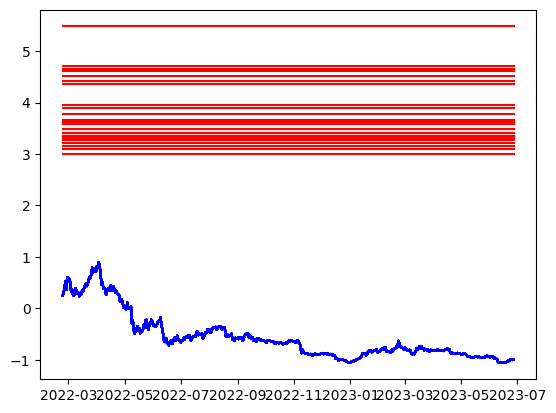

In [71]:
for i in range(1, 32):
    print(i)
    X_data, dict_chosen = utils.get_data_from_combination_number(i, all_dfs, data_names=data_names)
    X_train, y_train, X_test, y_test, scaler = sampling.prepare_input_data(X_data, y, test_size=TEST_SIZE, window_size=WINDOW_SIZE, step_size=STEP_SIZE, do_segmentation=False)

    data = np.array(df.loc[df.sest == i, "pet"].values[0]).reshape(-1, 1)
    data_unscaled = scaler.inverse_transform(data)

    plt.plot(df_tgt.Date, df_tgt.Price, color="blue")
    plt.plot(df_tgt.Date, data_unscaled, color="red")
    
    


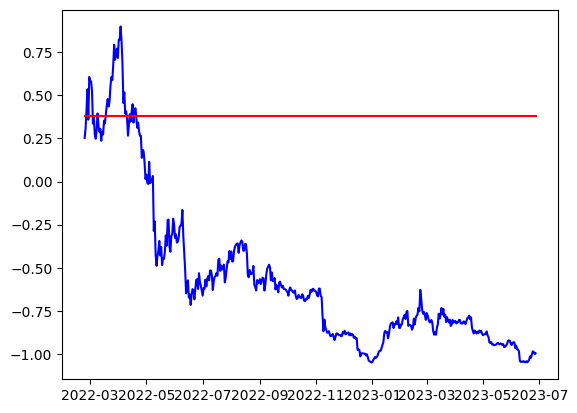

In [45]:
plt.plot(df_tgt.Date, df_tgt.Price, color="blue")
plt.plot(df_tgt.Date, df.loc[0, "pet"], color="red")

In [21]:
df1 = pd.read_csv(const.tezos_results_dir + "Predictions/Simple Model/Results_full_test_no_segmentation.csv")
df2 = pd.read_csv(const.tezos_results_dir + "Predictions/Simple Model/Backup/Results_full_test_no_segmentation.csv")
df3 = pd.concat([df2, df1]).reset_index(drop=True)
df3["number"] = df3.apply(lambda x: get_int_number(x), axis=1)

In [24]:
df0 = pd.read_csv(const.tezos_results_dir + "Predictions/Simple Model/Backup/Results_full_test_no_segmentation copy.csv")
df0

,market,network,social,supply,TI,MSE,RMSE,MAE,MAPE
0,0,0,0,0,1,0.0038,0.0616,0.0436,0.1629
1,0,0,0,1,0,7.5567,2.7489,2.6776,7.9388


In [22]:
df3

,market,network,social,supply,TI,MSE,RMSE,MAE,MAPE,number
0,0,0,0,1,0,6.7580,2.5996,2.5174,7.3925,2
1,0,0,0,1,1,0.0425,0.2062,0.1833,0.3834,3
2,0,0,1,0,0,2.5589,1.5997,1.5373,4.5193,4
3,0,0,1,0,1,0.0122,0.1103,0.0949,0.3316,5
4,0,0,1,1,0,6.0148,2.4525,2.2843,6.5338,6
5,0,0,1,1,1,0.0502,0.2241,0.1939,0.4782,7
6,0,1,0,0,0,1.6393,1.2804,1.2280,3.3619,8
7,0,1,0,0,1,0.0481,0.2194,0.1894,0.3929,9
8,0,1,0,1,0,2.1573,1.4688,1.4151,4.0959,10
9,0,1,0,1,1,0.3665,0.6054,0.5656,1.1514,11


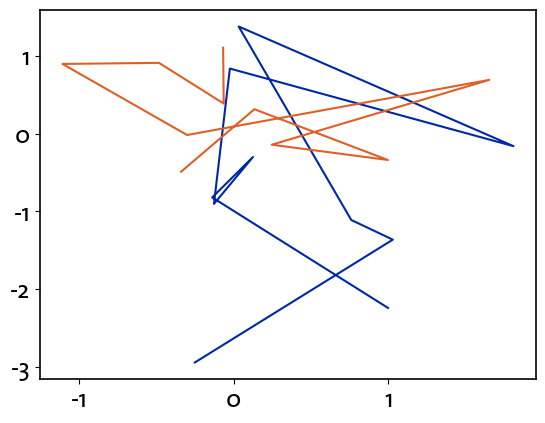

In [2]:
%matplotlib inline


import matplotlib as mpl
import matplotlib.pyplot as plt


import numpy as np
import networkx as nx
import scipy.special




uzh_colors_de = {'blau': '#0028a5', 'blau_80': '#3353b7', 'blau_60': '#667ec9', 'blau_40': '#99a9db', 'blau_20': '#ccd4ed',
               'ockerrot': '#dc6027', 'ockerrot_80': '#e38052', 'ockerrot_60': '#eaa07d', 'ockerrot_40': '#f1bfa9', 'ockerrot_20': '#f8dfd4',
               'lindengruen': '#91c34a', 'lindengruen_80': '#aad470', 'lindengruen_60': '#bfdf94', 'lindengruen_40': '#d5e9b7', 'lindengruen_20': '#eaf4db',
               'warmgelb': '#fede00', 'warmgelb_80': '#fbe651', 'warmgelb_60': '#fcec7c', 'warmgelb_40': '#fdf3a8', 'warmgelb_20': '#fef9d3',
               'grau': '#a3adb7', 'grau_80': '#b5bdc5', 'grau_60': '#c8ced4', 'grau_40': '#dadee2', 'grau_20': '#edeff1',
               'tuerkis': '#0b82a0', 'tuerkis_80': '#3c9fb6', 'tuerkis_60': '#6bb7c7', 'tuerkis_40': '#9ed0d9', 'tuerkis_20': '#cfe8ec',
               'flaschengruen': '#2a7f62', 'flaschengruen_80': '#569d85', 'flaschengruen_60': '#80b6a4', 'flaschengruen_40': '#abcec2', 'flaschengruen_20': '#d5e7e1'}



uzh_colors = {'blue': '#0028a5', 'blue_80': '#3353b7', 'blue_60': '#667ec9', 'blue_40': '#99a9db', 'blue_20': '#ccd4ed',
               'red': '#dc6027', 'red_80': '#e38052', 'red_60': '#eaa07d', 'red_40': '#f1bfa9', 'red_20': '#f8dfd4',
               'green': '#91c34a', 'green_80': '#aad470', 'green_60': '#bfdf94', 'green_40': '#d5e9b7', 'green_20': '#eaf4db',
               'yellow': '#fede00', 'yellow_80': '#fbe651', 'yellow_60': '#fcec7c', 'yellow_40': '#fdf3a8', 'yellow_20': '#fef9d3',
               'grey': '#a3adb7', 'grey_80': '#b5bdc5', 'grey_60': '#c8ced4', 'grey_40': '#dadee2', 'grey_20': '#edeff1',
               'turquoise': '#0b82a0', 'turquoise_80': '#3c9fb6', 'turquoise_60': '#6bb7c7', 'turquoise_40': '#9ed0d9', 'turquoise_20': '#cfe8ec',
               'green2': '#2a7f62', 'green2_80': '#569d85', 'green2_60': '#80b6a4', 'green2_40': '#abcec2', 'green2_20': '#d5e7e1'}


uzh_color_map = ['#0028a5', '#dc6027', '#91c34a', '#fede00', '#a3adb7', '#0b82a0', '#2a7f62', # FULL
                 '#667ec9', '#eaa07d', '#bfdf94', '#fcec7c', '#c8ced4', '#6bb7c7', '#80b6a4', # 60%
                 '#3353b7', '#e38052', '#aad470', '#fbe651', '#b5bdc5', '#3c9fb6', '#569d85', # 80%
                 '#99a9db', '#f1bfa9', '#d5e9b7', '#fdf3a8', '#dadee2', '#9ed0d9', '#abcec2', # 40%
                 '#ccd4ed', '#f8dfd4', '#eaf4db', '#fef9d3', '#edeff1', '#cfe8ec', '#d5e7e1'] # 20%



plt.rc('text', usetex=False)
plt.rcParams['font.family'] = 'sans-serif'

plt.rcParams['font.sans-serif'] = 'TheSans'
#plt.rcParams['text.usetex'] = True

mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
plt.rcParams['axes.labelsize'] = 26

plt.rc('axes', unicode_minus=False)


plt.rcParams['font.size'] = 18
mpl.rc('ytick', labelsize=18) 
mpl.rc('xtick', labelsize=18) 
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=uzh_color_map) 

plt.plot(np.random.randn(10,2), np.random.randn(10,2))

findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans
findfont: Generic family 'sans-serif'

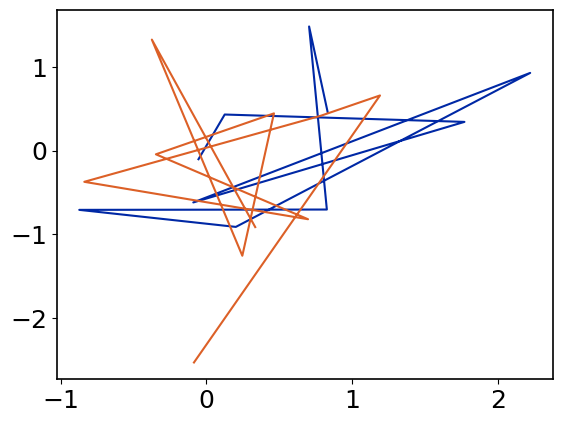

In [4]:
# Create test data

n_dates = 20
n_features = 3
a = np.random.rand(n_dates, n_features)
t = np.random.rand(n_dates, 1)

# a_w, t_w = sampling.apply_sliding_window(a, t, window_size=3, step_size=1)
X_train, y_train, X_test, y_test = sampling.prepare_input_dataset(a, t, test_size=0.2, do_segmentation=False, window_size=3, step_size=1)
train_loader = sampling.make_data_loader(X_train, y_train, batch_size=3)

In [5]:
input_dim = X_train.shape[2]  # Input feature dimension
output_dim = 1  # Output dimension
enc_emb_dim = 32  # Encoder embedding dimension
dec_emb_dim = 32  # Decoder embedding dimension
enc_hidden_dim = 64  # Encoder LSTM hidden dimension
dec_hidden_dim = 64  # Decoder LSTM hidden dimension
n_layers = 2  # Number of LSTM layers
dropout = 0.3  # Dropout probability
learning_rate = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create encoder and decoder instances
encoder = components.Encoder(input_dim, enc_emb_dim, enc_hidden_dim, n_layers, dropout).to(device)
attention = components.Attention(enc_hidden_dim, dec_hidden_dim).to(device)
decoder = components.Decoder(output_dim, dec_emb_dim, enc_hidden_dim, dec_hidden_dim, n_layers, dropout, attention).to(device)

# Create Seq2Seq model
model = LSTMmodel.LSTMSimple(input_size=input_dim, hidden_size=32, output_size=output_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:


train_loss = []
n_epochs = 10
print_progress = True
for epoch in range(n_epochs):
    for batch_data, batch_targets in train_loader:

        batch_data = batch_data.to(torch.float32)
        batch_targets = batch_targets.to(torch.float32)

        optimizer.zero_grad()

        outputs = model(batch_data)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    train_loss.append(loss.item())
    if print_progress and (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [10/10], Loss: 0.0140


In [ ]:
# Assuming 'model' is your trained Seq2Seq model
model.eval()  # Set the model in evaluation mode

with torch.no_grad():  # Disable gradient calculation
    # Provide historical price data as input
    # For example, 'src_input' can be a tensor of shape (batch_size, sequence_length, input_features)

    # Initialize an initial input for prediction (e.g., the last known price)
    input = X_test[:, -1, :]

    # Define the number of future time steps to predict
    num_future_steps = 1  # Adjust as needed

    predictions = []  # Store predicted prices

    for t in range(num_future_steps):
        output, _, _ = model.decoder(input, hidden, cell, encoder_outputs)  # Adjust decoder inputs as needed
        predictions.append(output)  # Store the predicted price

        # Update 'input' for the next time step (e.g., using 'output' or other relevant information)
        input = output  # This is a simple example; adapt as needed

    # 'predictions' now contains the predicted future stock prices


In [52]:
batch_size = 5
dataset = CustomDataset(a_w, t_w)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
for epoch in range(num_epochs):
    for batch_data, batch_target in data_loader:
        batch_data = batch_data.to(torch.float32)
        batch_target = batch_target.to(torch.float32)


        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 14.0186
Epoch [20/100], Loss: 7.5753
Epoch [30/100], Loss: 14.8946
Epoch [40/100], Loss: 10.6733
Epoch [50/100], Loss: 12.7114
Epoch [60/100], Loss: 7.7161
Epoch [70/100], Loss: 7.7336
Epoch [80/100], Loss: 10.9010
Epoch [90/100], Loss: 11.5098
Epoch [100/100], Loss: 4.9636


In [ ]:
# data = torch.randn(100, 5)
# print(data.shape)
# # Step 2: Create sequences of 10 time steps each
# sequence_length = 10
# sequences = [data[i:i+sequence_length] for i in range(0, len(data) - sequence_length + 1)]
# print(len(sequences), sequences[0].shape)

In [21]:
num_epochs = 100
for epoch in range(num_epochs):
    for batch_data, batch_target in train_loader:
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')






ValueError: too many values to unpack (expected 2)

In [23]:
df = pd.read_csv(const.input_X_dir + "Market.csv")
df_segment = pd.read_csv(const.segmentation_file)



In [27]:
def scale_per_segment(df, df_segments):
    columns = df.columns

    df = df.copy()
    df["date"] = const.date_range

    result = np.array([])
    for i, row in df_segments.iterrows():
        start_date = pd.to_datetime(row['Start Date'])
        end_date = pd.to_datetime(row['End Date'])

        segment = df[(df.date >= start_date) & (df.date < end_date)]
        if i == df_segments.shape[0] -1:
            segment = df[(df.date >= start_date) & (df.date <= end_date)]
        
        arr = np.array(segment.drop("date", axis=1).values)
        scaler = StandardScaler()
        arr_scaled = scaler.fit_transform(arr)

        if len(result) == 0:
            result = arr_scaled
        else:
            result = np.concatenate((result, arr_scaled), axis= 0)
    
    result = pd.DataFrame(result)
    result.columns = columns
    return result

In [28]:
res = scale_per_segment(df, df_segment)
res

,market_cap,LTC_price,LTC_market_caps,BTC_price,BTC_market_caps,XRP_price,XRP_market_caps,ETH_price,ETH_market_caps,BTC_total_volumes,ETH_total_volumes,total_volume,LTC_total_volumes,volume,XRP_total_volumes,high
0,2.141880,3.139638,3.143645,3.126771,3.093636,0.340027,0.269455,2.958607,2.966521,3.983241,4.664831,0.681256,1.632791,0.595386,-0.490830,2.439142
1,1.190440,2.888764,2.886273,2.919862,2.884075,0.166515,0.101656,2.849848,2.857406,1.402443,0.730171,0.862596,-1.430973,0.015273,-0.705887,2.268895
2,1.893392,3.098179,3.106512,2.547527,2.505105,0.271489,0.201331,2.959977,2.970866,0.722038,0.092974,1.807049,-0.794233,-0.610700,-0.585483,2.264166
3,2.145570,2.434424,2.420171,1.385038,1.316190,0.154716,0.088450,2.780637,2.789912,0.923921,-0.273556,0.516489,-0.884327,0.197581,-0.744142,2.235791
4,1.946089,2.645365,2.642273,1.464713,1.400220,0.202247,0.134397,2.819702,2.831100,0.943732,0.095857,-0.162366,-1.200746,7.878629,-0.732887,2.292540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786,-1.519159,0.207324,0.281545,1.385386,1.401867,1.214360,1.267157,1.011497,1.008342,-0.297047,0.085912,-0.351188,-0.153395,-0.670030,-0.069391,-1.367541
1787,-1.303806,0.669331,0.739404,1.531781,1.543305,1.229350,1.296041,1.076375,1.072649,-0.086473,0.008540,-0.399727,0.181590,-0.427391,-0.561568,-1.245579
1788,-1.111020,0.524111,0.594758,1.512484,1.525225,1.066315,1.150123,1.014830,1.010483,-0.846746,-0.625268,-0.415733,-0.025324,-0.260797,-1.037716,-1.074962
1789,-1.122894,0.401287,0.470854,1.494954,1.508785,1.115994,1.190344,1.105862,1.101453,-0.822971,-0.269938,-0.448265,-0.416851,-0.621547,-1.036344,-1.251417


In [7]:
a = np.array([[1,1,1], [12,4,4], [3,3,3]])
a[2:, ]

array([[3, 3, 3]])